## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc
#import sys
# To be able to import from lib directory
#sys.path.append(r'..\lib\\')
#do not show warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
gc.collect()

31

## Datos crudos

In [3]:
#Cargar todos los datos
saber11_20171 = pd.read_csv(r'data\Saber_11__2017-1.csv')
saber11_20172 = pd.read_csv(r'data\Saber_11__2017-2.csv')
saber11_20181 = pd.read_csv(r'data\Saber_11__2018-1.csv')
saber11_20182 = pd.read_csv(r'data\Saber_11__2018-2.csv')
saber11_20191 = pd.read_csv(r'data\Saber_11__2019-1.csv')
saber11_20192 = pd.read_csv(r'data\Saber_11__2019-2.csv')

In [4]:
#Lista de DB
datos = [saber11_20171, 
         saber11_20172, 
         saber11_20181, 
         saber11_20182, 
         saber11_20191, 
         saber11_20192]

In [5]:
#Columnas a minúscula
for peri in datos:
    peri.columns = [i.lower() for i in peri.columns]

In [6]:
variables_cole = [i for i in saber11_20171.columns if 'cole' in i]
variables_estu = [i for i in saber11_20171.columns if 'estu' in i]
variables_fami = [i for i in saber11_20171.columns if 'fami' in i]

key_cole = ['cole_cod_dane_establecimiento', 
            'cole_cod_dane_sede',
            'cole_cod_mcpio_ubicacion',
            'cole_cod_depto_ubicacion',
            'cole_naturaleza',
            'cole_calendario']

key_estu = key_cole + ['fami_estratovivienda','punt_global','estu_horassemanatrabaja','periodo','estu_consecutivo']

## Colegios

In [53]:
#Concat de todos los periodos: cada fila es un colegio
key = key_cole + ['cole_nombre_sede', 'cole_mcpio_ubicacion','cole_depto_ubicacion']
colegios_2017_2019 = pd.concat([saber11_20171[key].drop_duplicates(), 
                                saber11_20172[key].drop_duplicates(),
                                saber11_20181[key].drop_duplicates(), 
                                saber11_20182[key].drop_duplicates(), 
                                saber11_20191[key].drop_duplicates(), 
                                saber11_20192[key].drop_duplicates()])

In [54]:
#Algunos duplicados por un cambio en el nombre
colegios_2017_2019.drop_duplicates(inplace=True)

In [55]:
#Revisar duplicados
colegios_2017_2019[key_cole].drop_duplicates().shape[0] == colegios_2017_2019.shape[0]

False

In [56]:
#Un solo nombre por colegio, escogido de forma alfabética
colegios_2017_2019_ = pd.pivot_table(data=colegios_2017_2019,
                            index=key_cole,
                            aggfunc={'cole_nombre_sede':'min','cole_mcpio_ubicacion':'min','cole_depto_ubicacion':'min'}).reset_index()

In [57]:
colegios_2017_2019_[key_cole].drop_duplicates().shape[0] == colegios_2017_2019_.shape[0]

True

## Estudiantes

In [58]:
#Concat de todos los periodos: cada fila es un estudiante
estudiantes_2017_2019 = pd.concat([saber11_20171[key_estu], 
                                   saber11_20172[key_estu], 
                                   saber11_20181[key_estu], 
                                   saber11_20182[key_estu], 
                                   saber11_20191[key_estu], 
                                   saber11_20192[key_estu]])

In [59]:
#Null check
estudiantes_2017_2019.isna().sum()

cole_cod_dane_establecimiento      0
cole_cod_dane_sede                 0
cole_cod_mcpio_ubicacion           0
cole_cod_depto_ubicacion           0
cole_naturaleza                    0
cole_calendario                    0
fami_estratovivienda              26
punt_global                        0
estu_horassemanatrabaja          381
periodo                            0
estu_consecutivo                   0
dtype: int64

In [60]:
#Fill nulls
estudiantes_2017_2019['fami_estratovivienda'].fillna('A-Sin info',inplace=True)
estudiantes_2017_2019['estu_horassemanatrabaja'].fillna('A-Sin info',inplace=True)

In [61]:
#Duplicates check
estudiantes_2017_2019[['estu_consecutivo']].drop_duplicates().shape[0] == estudiantes_2017_2019.shape[0]


True

## Cálculos

In [101]:
#Método 1: Promedio por institución sobre todos los periodos
#Cálculo del promedio de todos lo periodos por colegio y su sigma
#Promedio
cole_acumulado = pd.pivot_table(data=estudiantes_2017_2019,
                                index=key_cole,
                                aggfunc={'punt_global':'mean','estu_consecutivo':'count'}).reset_index()
cole_acumulado.rename(columns={"punt_global": "prom_punt_global","estu_consecutivo": "num_evaluados"},inplace=True)

#Desviación estándar
cole_acumulado1 = pd.pivot_table(data=estudiantes_2017_2019,
                                 index=key_cole,
                                 aggfunc={'punt_global':np.std}).reset_index() 
cole_acumulado1.rename(columns={"punt_global": "stdve_punt_global"},inplace=True)

#Resultados
cole_acumulado_final = cole_acumulado.merge(cole_acumulado1[key_cole+['stdve_punt_global']], 
                                            how='left',
                                            left_on=key_cole, 
                                            right_on=key_cole)

cole_acumulado_final['stdve_punt_global'].fillna(0, inplace=True)

#Criterio de Andes = Promedio - 1.25(Desviaciones estándar)
cole_acumulado_final['criterio_andes'] = cole_acumulado_final['prom_punt_global'] - 1.25*cole_acumulado_final['stdve_punt_global']

#True: Criterio Andes >= 310 , False: Criterio Andes < 310
cole_acumulado_final['entrada_directa'] = [False]*cole_acumulado_final.shape[0]
cole_acumulado_final['entrada_directa'][cole_acumulado_final.criterio_andes >= 310] = True


In [63]:
resultados_cole = cole_acumulado_final[(cole_acumulado_final.entrada_directa) & (cole_acumulado_final.cole_calendario == 'B')].sort_values(by='criterio_andes', ascending=False)

In [64]:
resultados_final = resultados_cole.merge(colegios_2017_2019_,
                                         left_on=key_cole, 
                                         right_on=key_cole)

In [108]:
#Método 2: Promedio por periodo-institución y luego por institución
#Cálculo del promedio de cada periodo por colegio, luego sacar el promedio por colegio y su sigma
#Promedio periodo-colegio
cole_acumulado_periodo = pd.pivot_table(data=estudiantes_2017_2019,
                                index=key_cole + ['periodo'],
                                aggfunc={'punt_global':'mean','estu_consecutivo':'count'}).reset_index()
cole_acumulado_periodo.rename(columns={"punt_global": "prom_punt_global","estu_consecutivo": "num_evaluados"},inplace=True)

#Promedio colegio
cole_acumulado_2 = pd.pivot_table(data=cole_acumulado_periodo,
                                index=key_cole,
                                aggfunc={'prom_punt_global':'mean','num_evaluados':'sum'}).reset_index()


#Desviación estándar
cole_acumulado_2_1 = pd.pivot_table(data=cole_acumulado_periodo,
                                 index=key_cole,
                                 aggfunc={'prom_punt_global':np.std}).reset_index() 
cole_acumulado_2_1.rename(columns={"prom_punt_global": "stdve_punt_global"},inplace=True)

#Resultados
cole_acumulado_final_1 = cole_acumulado_2.merge(cole_acumulado_2_1[key_cole+['stdve_punt_global']], 
                                                how='left',
                                                left_on=key_cole, 
                                                right_on=key_cole)

cole_acumulado_final_1.fillna(0, inplace=True)


#Criterio de Andes = Promedio - 1.25(Desviaciones estándar)
cole_acumulado_final_1['criterio_andes'] = cole_acumulado_final_1['prom_punt_global'] - 1.25*cole_acumulado_final_1['stdve_punt_global']

#True: Criterio Andes >= 310 , False: Criterio Andes < 310
cole_acumulado_final_1['entrada_directa'] = [False]*cole_acumulado_final_1.shape[0]
cole_acumulado_final_1['entrada_directa'][cole_acumulado_final_1.criterio_andes >= 310] = True


In [109]:
resultados_cole_1 = cole_acumulado_final_1[(cole_acumulado_final_1.entrada_directa) & (cole_acumulado_final_1.cole_calendario == 'B')].sort_values(by='criterio_andes', ascending=False)

In [111]:
resultados_final_1 = resultados_cole_1.merge(colegios_2017_2019_,
                                             left_on=key_cole, 
                                             right_on=key_cole)

In [117]:
coles = ['cole_depto_ubicacion', 
         'cole_mcpio_ubicacion', 
         'cole_nombre_sede',
         'cole_calendario',
         'num_evaluados',
         'prom_punt_global',
         'stdve_punt_global',
         'criterio_andes',
         'entrada_directa']
resultados_final[coles].to_csv(r'data\59_colegios.csv')

In [131]:
resultados_final['cole_depto_ubicacion'].drop_duplicates()

0        SANTANDER
2            VALLE
4           BOGOTA
9     CUNDINAMARCA
17       ANTIOQUIA
20       RISARALDA
29           CESAR
32         BOLIVAR
37           CAUCA
40       ATLANTICO
47         QUINDIO
Name: cole_depto_ubicacion, dtype: object

## Insights

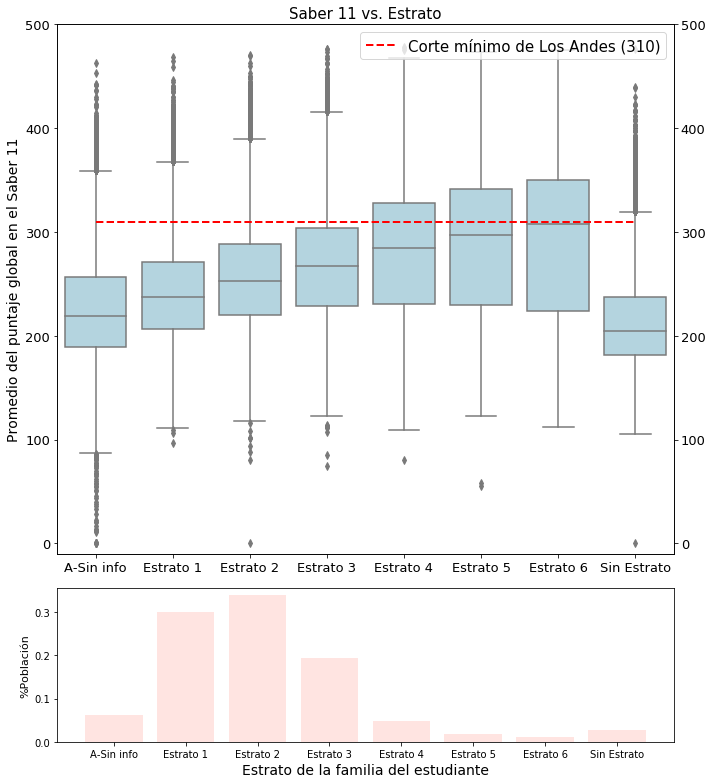

In [132]:
#Saber11_Histórico_vs_Estrato
estudiantes_2017_2019['fami_estratovivienda'][estudiantes_2017_2019['fami_estratovivienda']=='-'] = ['A-Sin info']*estudiantes_2017_2019.shape[0]
data = estudiantes_2017_2019.sort_values(by="fami_estratovivienda")

data['estrato'] = data['fami_estratovivienda']
distribucion = pd.pivot_table(data=data,index=['fami_estratovivienda'],aggfunc={'estrato':'count'}).reset_index()

fig = plt.figure(figsize=(10,11))
gs = fig.add_gridspec(4, 4)
ax1 = plt.subplot(gs[0:3, :])
ax3 = plt.subplot(gs[3, :])
ax2 = ax1.twinx()

sns.boxplot(x="fami_estratovivienda", 
            y="punt_global", 
            data=data,
            color='lightblue',
            ax=ax1)

ax1.set_title('Saber 11 vs. Estrato',y=1,fontsize=15)
ax1.set_xlabel('',  fontsize=14)
ax1.set_ylabel('Promedio del puntaje global en el Saber 11', fontsize=14)
ax1.set_ylim(-10,500)
ax1.tick_params(axis='both', which='major', labelsize=13)

ax2.plot([310]*8,
         color='r',
         ls='--', 
         linewidth=2, 
         label='Corte mínimo de Los Andes (310)')
ax2.set_ylim(-10,500)
ax2.legend(loc="best",fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=13)

ax3.bar(x=distribucion['fami_estratovivienda'], 
        height=distribucion['estrato']/sum(distribucion['estrato']),
        color='mistyrose')
ax3.set_xlabel('Estrato de la familia del estudiante',  fontsize=14,y=15)
ax3.set_ylabel('%Población',  fontsize=11)
fig.tight_layout()


#plt.savefig(r'C:\Users\Usuario\Pictures\Saber11\saber11_estrato.png')
#plt.close()

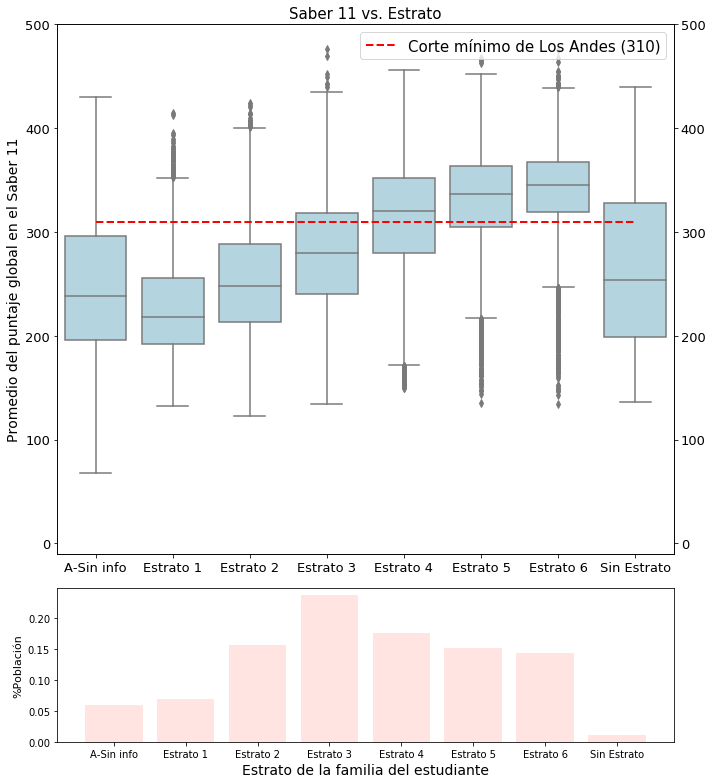

In [133]:
#Saber11_B_vs_Estrato
data = estudiantes_2017_2019[estudiantes_2017_2019.periodo.isin([20191,20181,20171])]
data['fami_estratovivienda'][data['fami_estratovivienda']=='-'] = ['A-Sin info']*data.shape[0]
data = data.sort_values(by="fami_estratovivienda")

data['estrato'] = data['fami_estratovivienda']
distribucion = pd.pivot_table(data=data,index=['fami_estratovivienda'],aggfunc={'estrato':'count'}).reset_index()

fig = plt.figure(figsize=(10,11))
gs = fig.add_gridspec(4, 4)
ax1 = plt.subplot(gs[0:3, :])
ax3 = plt.subplot(gs[3, :])
ax2 = ax1.twinx()

sns.boxplot(x="fami_estratovivienda", 
            y="punt_global", 
            data=data,
            color='lightblue',
            ax=ax1)

ax1.set_title('Saber 11 vs. Estrato',y=1,fontsize=15)
ax1.set_xlabel('',  fontsize=14)
ax1.set_ylabel('Promedio del puntaje global en el Saber 11', fontsize=14)
ax1.set_ylim(-10,500)
ax1.tick_params(axis='both', which='major', labelsize=13)

ax2.plot([310]*8,
         color='r',
         ls='--', 
         linewidth=2, 
         label='Corte mínimo de Los Andes (310)')
ax2.set_ylim(-10,500)
ax2.legend(loc="best",fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=13)

ax3.bar(x=distribucion['fami_estratovivienda'], 
        height=distribucion['estrato']/sum(distribucion['estrato']),
        color='mistyrose')
ax3.set_xlabel('Estrato de la familia del estudiante',  fontsize=14,y=15)
ax3.set_ylabel('%Población',  fontsize=11)
fig.tight_layout()


#plt.savefig(r'C:\Users\Usuario\Pictures\Saber11\saber11_estrato.png')
#plt.close()

In [ ]:
#Saber11_vs_Estrato
fig = plt.figure(figsize=(10,11))
gs = fig.add_gridspec(4, 4)
ax1 = plt.subplot(gs[0:3, :])
ax3 = plt.subplot(gs[3, :])
ax2 = ax1.twinx()
sns.boxplot(x="cole_depto_ubicacion", 
            y="punt_global", 
            data=data,
            color='lightblue',
            ax=ax1)
ax1.set_title('Saber 11 vs. Estrato',y=1,fontsize=15)
ax1.set_xlabel('',  fontsize=14)
ax1.set_ylabel('Promedio del puntaje global en el Saber 11', fontsize=14)
ax1.set_ylim(-10,500)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.plot([310]*distribucion_depto.shape[0],color='r',ls='--', linewidth=2, label='Corte Los Andes (310)')
ax2.set_ylim(-10,500)
ax2.legend(loc="best",fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax1.tick_params(axis='x', which='major', labelsize=9,rotation=90)
ax3.bar(x=distribucion_depto['cole_depto_ubicacion'], height=distribucion_depto['depto']/sum(distribucion_depto['depto']),color='mistyrose')
ax3.set_xlabel('Estrato de la familia del estudiante',  fontsize=14,y=15)
ax3.tick_params(axis='x', which='major', labelsize=7,rotation=90)
ax3.set_ylabel('%Población',  fontsize=11)
fig.tight_layout()


#plt.savefig(r'C:\Users\Usuario\Pictures\Saber11\saber11_estrato.png')
#plt.close()

In [ ]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0:2, :])
f3_ax1.set_title('gs[0, :]')
#f3_ax2 = fig3.add_subplot(gs[1, :-1])
#f3_ax2.set_title('gs[1, :-1]')
#f3_ax3 = fig3.add_subplot(gs[1:, -1])
#f3_ax3.set_title('gs[1:, -1]')
#f3_ax4 = fig3.add_subplot(gs[-1, 0])
#f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[2, :])
f3_ax5.set_title('gs[-0, :]')

In [ ]:
#sns.countplot(data['fami_estratovivienda'])
data['estrato'] = data['fami_estratovivienda']
distribucion = pd.pivot_table(data=data,index=['fami_estratovivienda'],aggfunc={'estrato':'count'}).reset_index()

In [ ]:
#sns.countplot(data['fami_estratovivienda'])
data['depto'] = data['cole_depto_ubicacion']
distribucion_depto = pd.pivot_table(data=data,index=['cole_depto_ubicacion'],aggfunc={'depto':'count'}).reset_index()

In [ ]:
distribucion_depto

In [ ]:
plt.bar(x=distribucion['fami_estratovivienda'], height=distribucion['estrato']/sum(distribucion['estrato']))

In [ ]:
sum(data['estrato'])

In [ ]:
estudiantes_2017_2019.dropna(inplace=True)
fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(1,1,1)
sns.catplot(x="estu_horassemanatrabaja", 
            y="punt_global", 
            kind='box',
            data=estudiantes_2017_2019.sort_values(by="estu_horassemanatrabaja"),
            #order=order,
            ax=ax1)#hue="kind"
plt.show()

In [ ]:
df = datos[0]
pd.pivot_table(data =df[df.cole_calendario == 'B'][key+['punt_global']], index=key, aggfunc={'punt_global':'mean'}).reset_index()

In [ ]:
estudiantes_2017_2019

In [ ]:
saber11_20191[(saber11_20191['cole_nombre_sede'].str.contains("MARY"))&(saber11_20191['cole_nombre_sede'].str.contains("MARY"))][key+['cole_nombre_sede','punt_global']]

In [ ]:
bus.sort_values(by="punt_global")

In [ ]:
saber11_20191[saber11_20191['cole_nombre_sede'].str.contains("PORTALES")]

In [ ]:
variables = ['cole_nombre_sede',
             'cole_nombre_establecimiento',
             'cole_calendario',
             'cole_bilingue',
             'cole_area_ubicacion',
             'cole_depto_ubicacion',
             'fami_estratovivienda',
             'punt_global',
             'cole_naturaleza']

filas = ['cole_nombre_sede']
valores = ['punt_grlobal']

In [ ]:
df = saber11_20192

In [ ]:
temp = pd.pivot_table(data =df[df.cole_calendario == 'B'], index=filas, aggfunc={'punt_global':'mean'}).reset_index()

In [ ]:
temp['AÑO'] = ['20192']*temp.shape[0]

In [ ]:
saber112017 = temp

In [ ]:
todo_2019 = pd.concat([saber112017,temp])

In [ ]:
np.std

In [ ]:
todo_2017.columns = [i.lower() for i in todo_2017.columns]
todo_2018.columns = [i.lower() for i in todo_2018.columns]

In [ ]:
todo_2017_a_2019 = pd.concat([todo_2017,todo_2018,todo_2019])

In [ ]:
todo_2017_a_2019

In [ ]:
saber11_20191[saber11_20191['cole_nombre_sede'].str.contains("PORTALES")]['cole_cod_dane_establecimiento'].drop_duplicates()

In [ ]:
311001045160

In [ ]:
info_minada_pasa = info_minda[info_minda.admi>=310].sort_values(by=['admi'],ascending=False)
info_minada_pasa.reset_index(inplace=True)

In [ ]:
resultados = pd.pivot_table(data =todo_2017_a_2019, index=['cole_nombre_sede'], aggfunc={'punt_global':'mean'}).reset_index()
resultados.rename(columns={"punt_global": "prom_punt_global"},inplace=True)
resultados1 = pd.pivot_table(data =todo_2017_a_2019, index=['cole_nombre_sede'], aggfunc={'punt_global':np.std}).reset_index()
resultados1.rename(columns={"punt_global": "sigma_punt_global"},inplace=True)

In [ ]:
info_minda = pd.concat([resultados,resultados1['sigma_punt_global']],axis=1)

In [ ]:
info_minda['sigma_punt_global'].fillna(0,inplace=True)

In [ ]:
info_minda['admi'] = info_minda['prom_punt_global']-1.25*info_minda['sigma_punt_global']

In [ ]:
for i in info_minada_pasa.head(71).cole_nombre_sede:
    print(i)

In [ ]:
for i in a:
    print(i)

In [ ]:
resultados_saber111['AÑO'] = [2018]*resultados_saber111.shape[0]

In [ ]:
saber_11_2018 = pd.concat([resultados_saber11, resultados_saber111])

In [ ]:
saber_11_2018

In [ ]:
saber_11_2017

In [ ]:
colegios = pd.read_csv(r'C:\Users\Usuario\Downloads\colegios2.csv')

In [ ]:
total[total.index==105]['COLEGIO']

In [ ]:
total[total['COLEGIO'].str.contains("Andino")]

In [ ]:
top[top['COLEGIO'].str.contains("Marymount")]

In [ ]:
total = colegios.sort_values(by='PROMEDIO',ascending=False)

In [ ]:
top = colegios[colegios.PROMEDIO >= 310].head(61)

In [ ]:
top.DEPARTAMENTO.drop_duplicates()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.countplot(top.DEPARTAMENTO)

plt.show()

In [ ]:
30/61

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(top.NATURALEZA)

plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(top.CALENDARIO)

plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(top.EVALUADOS)

plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(top.JORNADA)

plt.show()

In [ ]:
admitidos_uniandes = 2869
egresados_top_61 = sum(top.EVALUADOS)

In [ ]:
egresados_top_61/admitidos_uniandes

In [ ]:
semestres = []
last = '20161'
for i in range(0,8):
    print(i)
    if(last[-1:]=='1'):
        new = last[:-1]+'2'
        print(new)
        last = new
        semestres.append(last)
    else
        print(last[3]) #= str(int(last[3:-1]) + 1)
        

In [ ]:
a = 'afas'

In [ ]:
a[1]

In [ ]:
d = {'Semestre': ['20161', '20162','20171','20172','20181','20182','20191','20192','20201'], 
     'Admitidos': [4214, 2662, 3453, 2829, 3800, 2936,  3962, 2869, 3962+400]}
df = pd.DataFrame(data=d)

In [ ]:
pd.concat([df,df],axis=1)

In [ ]:
import numpy as np
print(np.mean(df.Admitidos),np.median(df.Admitidos), np.std(df.Admitidos))

In [ ]:
egresados_top_61/3454

In [ ]:
top['PROMEDIO_ROUD'] = round(top.PROMEDIO)

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(top.PROMEDIO_ROUD)